# Лабораторная работа 1, Степанов 6408, 1 вариант

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



Изображения 0 класса


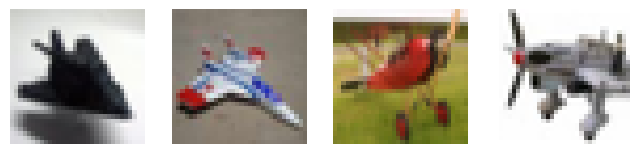

Изображения 1 класса


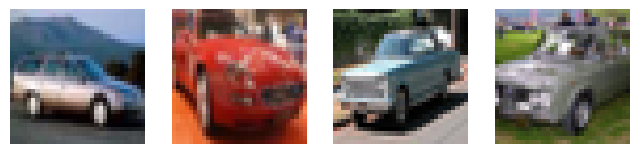

Изображения 2 класса


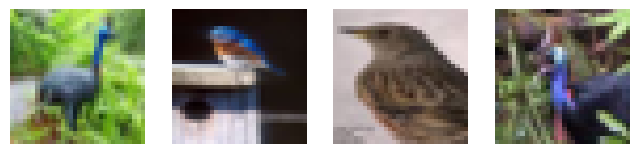

Изображения 3 класса


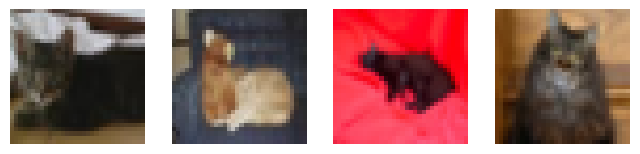

Изображения 4 класса


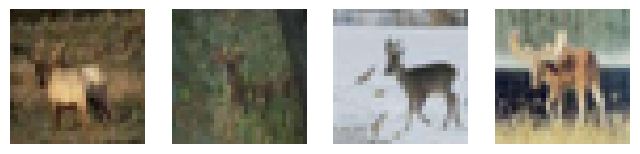

Изображения 5 класса


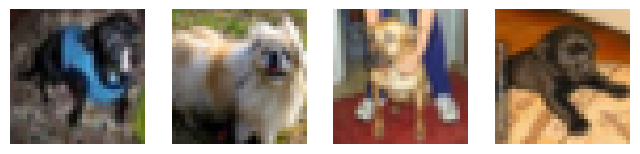

Изображения 6 класса


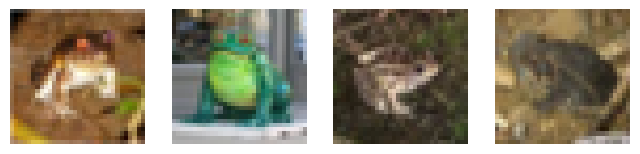

Изображения 7 класса


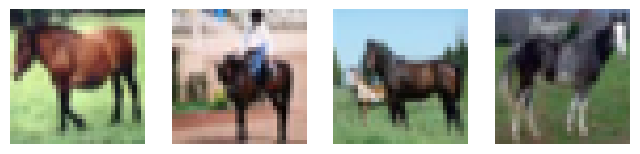

Изображения 8 класса


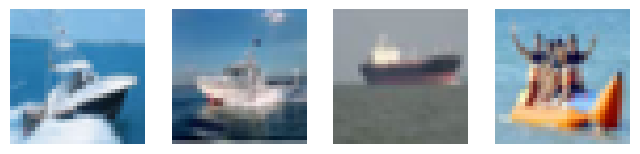

Изображения 9 класса


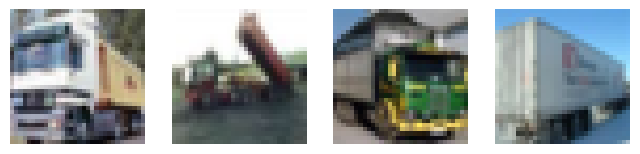

In [3]:
num_examples_per_class = 4

for i in np.unique(y_train):
    print('Изображения', i ,'класса')
    fig, axes = plt.subplots(1, num_examples_per_class, figsize=(8, 3))
    indexes_curent_class = np.where(y_train == i)[0][:num_examples_per_class]
    for j in range(num_examples_per_class):
        plt.subplot(1, num_examples_per_class, j + 1)
        plt.imshow(X_train[indexes_curent_class[j]] / 255)
        plt.axis('off') # отключение осей
    plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

Уменьшил выбору из-за нехватки оперативной памяти

In [4]:
limit_train = 5000
limit_test = 2000

In [5]:
X_train, y_train = X_train[:limit_train], y_train[:limit_train]
X_test, y_test = X_test[:limit_test], y_test[:limit_test]

In [6]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print('Обучающая до:', X_train.shape)
print('Тестовая после:', X_test.shape)
print('Метки обучающей выборки:', y_train.shape)
print('Метки тестовой выборки:', y_test.shape)

Обучающая до: (5000, 3072)
Тестовая после: (2000, 3072)
Метки обучающей выборки: (5000,)
Метки тестовой выборки: (2000,)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

## k_nearest_neighbor.py

In [7]:
from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange
from statistics import mode

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        if num_loops == 0:
            self.dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            self.dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            self.dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(self.dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension, nor use np.linalg.norm().          #
                #####################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                diff_squares = np.sum((X[i] - self.X_train[j]) ** 2)
                dists[i, j] = np.sqrt(diff_squares)

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            # Do not use np.linalg.norm().                                        #
            #######################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            diff_squares = np.sum((X[i] - self.X_train) ** 2, axis=1)
            dists[i, :] = np.sqrt(diff_squares)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy,                #
        # nor use np.linalg.norm().                                             #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        sum_squares = np.add.outer(np.sum(X**2, axis=1), np.sum(self.X_train**2, axis=1))
        prod_matrix = np.dot(X, self.X_train.T)
        dists = np.sqrt(sum_squares - 2 * prod_matrix)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            closest_y = list(self.y_train[np.argsort(dists[i])[:k]])

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            y_pred[i] = mode(closest_y)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

In [8]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [9]:
# Предсказание меток для тестовых данных с использованием классификатора
predicts = [[] for _ in range(3)]
dists = [[] for _ in range(3)]
for i in range(3):
    predicts[i] = classifier.predict(X_test, num_loops=i) 
    dists[i] = classifier.dists
    print(f"loops: {i}")
    print(dists[i][:5,:5])
    print(predicts[i][:15])

loops: 0
[[3803.92350081 4210.59603857 5504.0544147  3473.88960677 4371.58632535]
 [6336.83367306 5270.28006846 4040.63608854 6430.498892   5350.64407338]
 [5224.83913628 4250.64289255 3773.94581307 5213.55799814 3761.53572361]
 [5265.83754022 4274.49459001 4593.32254474 5692.80598651 4982.8210885 ]
 [3163.80277514 4231.52395716 6134.35889071 2953.75032797 4255.45825969]]
[4. 9. 8. 8. 4. 4. 3. 2. 5. 8. 2. 8. 5. 7. 2.]
loops: 1
[[3803.92350081 4210.59603857 5504.0544147  3473.88960677 4371.58632535]
 [6336.83367306 5270.28006846 4040.63608854 6430.498892   5350.64407338]
 [5224.83913628 4250.64289255 3773.94581307 5213.55799814 3761.53572361]
 [5265.83754022 4274.49459001 4593.32254474 5692.80598651 4982.8210885 ]
 [3163.80277514 4231.52395716 6134.35889071 2953.75032797 4255.45825969]]
[4. 9. 8. 8. 4. 4. 3. 2. 5. 8. 2. 8. 5. 7. 2.]
loops: 2
[[3803.92350081 4210.59603857 5504.0544147  3473.88960677 4371.58632535]
 [6336.83367306 5270.28006846 4040.63608854 6430.498892   5350.64407338]
 

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


In [10]:
def visual_dists(distances, loops_param):
    plt.figure(figsize=(7, 5))
    plt.imshow(distances, cmap='viridis', aspect='auto')
    plt.colorbar(label='Расстояние')
    plt.xlabel('Обучающая выборка')
    plt.ylabel('Тестовая выборка')
    plt.title(f"Матрица расстояний функции compute_distances_{loops_param}")
    plt.show()

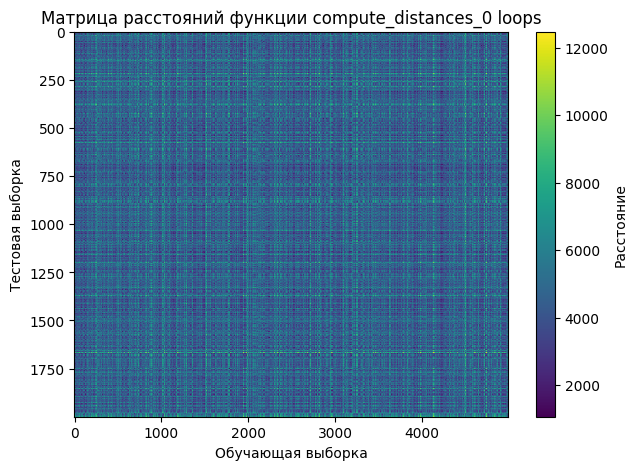

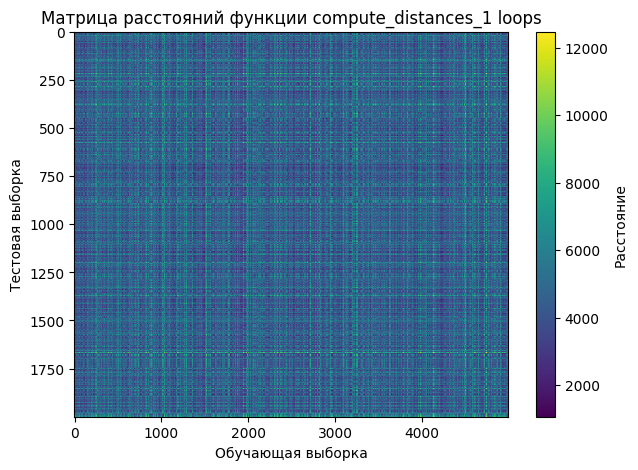

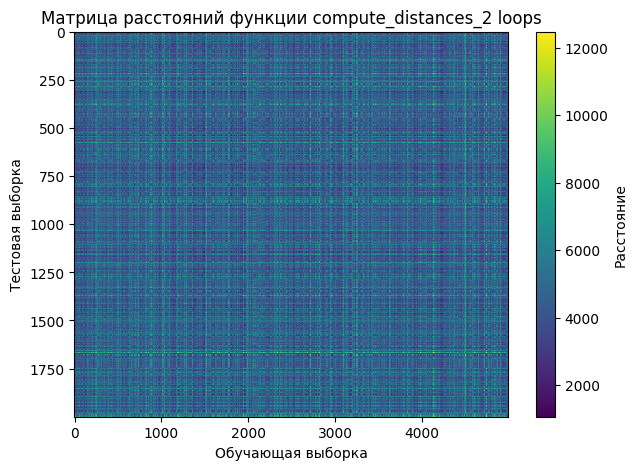

In [11]:
for i in range(3):
    visual_dists(dists[i], f"{i} loops")


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [12]:
np.mean(predicts[0] == y_test)

0.269

1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

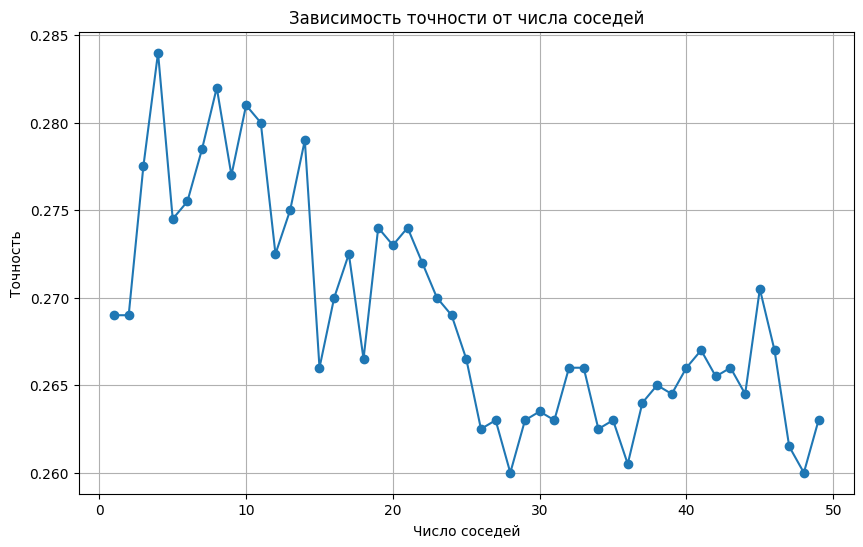

In [13]:
k_neighbors = list(range(1, 50))
accuracy = []
for i in k_neighbors:
    accuracy.append(np.mean(classifier.predict(X_test, k=i) == y_test))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_neighbors, accuracy, marker='o')
plt.title('Зависимость точности от числа соседей')
plt.xlabel('Число соседей')
plt.ylabel('Точность')
plt.grid(True)

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [14]:
best_k_index = np.argmax(accuracy)
best_k = k_neighbors[best_k_index]
best_accuracy = accuracy[best_k_index]

print(f"Лучшая точность {best_accuracy} соответствует k = {best_k}")

Лучшая точность 0.284 соответствует k = 4



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [15]:
new_predicts = [[] for _ in range(3)]
new_dists = [[] for _ in range(3)]
for i in range(3):
    new_predicts[i] = classifier.predict(X_test, k=best_k, num_loops=i) 
    new_dists[i] = classifier.dists
    print(f"loops: {i}")
    print(np.mean(new_predicts[i] == predicts[i]))

loops: 0
0.736
loops: 1
0.736
loops: 2
0.736


1.11 Сделайте выводы по результатам 1 части задания.

В первой части задания был написан классификатор, основанный на методе k ближайших соседей. Реализованный метод имеет большую вычислительную сложность.

По графику зависимости точности, зависящей от числа соседей видно, что наилучшаяя точность достигается при k = 4. Точность равна примерно 28.4%.

Переобучив модель можно достигнуть повышения точности. Cтоит отметить, что данный метод k-ближавйших соседей имеет высокую вычислительную сложность, что сказывается на времени работы программы. Также точность классификации составила на неполном тестовом наборе данных. В теории, используя полные выборки, можно получить лучшие результаты, говорящие о том, что для данной задачи классификатор работает достаточно эффективно.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [16]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10

cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validate data shape: ', X_val.shape)
print('Validate labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (40000, 3072)
Training labels shape:  (40000,)
Validate data shape:  (10000, 3072)
Validate labels shape:  (10000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[130.7684   136.171275 132.65505  130.20785  135.563275 131.963675
 131.0624   136.314875 132.6495   131.50975 ]


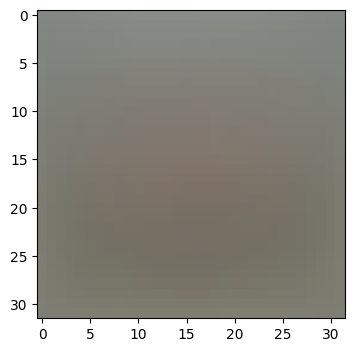

(40000, 3073) (10000, 3073) (10000, 3073)


In [17]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



## linear_svm.py

In [18]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]
                dW[:, y[i]] -= X[i]

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dW /= num_train
    dW += 2 * reg * W # производная регуляризации

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    return loss, dW



def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    num_train = X.shape[0]
    scores = X.dot(W)

    # вычисление отступов с помощью соотнесения классов с ищображениями
    margins = np.maximum(0, scores - np.reshape(scores[(range(scores.shape[0]), y)], (-1, 1)) + 1)
    
    # у изображений с корректным классом отступов не будет
    margins[np.arange(margins.shape[0]), y] = 0

    loss = np.sum(margins)
    loss /= num_train
    loss += reg * np.sum(W * W)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    margins[margins > 0] = 1
    sum_margins = np.sum(margins, axis=1) # сумма 
    margins[np.arange(margins.shape[0]), y] = -sum_margins
    
    dW = X.T.dot(margins)
    dW /= num_train
    dW += reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW


In [19]:
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_train, y_train, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.784109



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

## gradient_check.py

In [20]:
from __future__ import print_function
from builtins import range
from past.builtins import xrange

import numpy as np
from random import randrange

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              %(grad_numerical, grad_analytic, rel_error))


In [21]:
loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_train, y_train, 5e1)
f = lambda w: svm_loss_naive(w, X_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 10.797458 analytic: 10.796211, relative error: 5.776678e-05
numerical: -6.007789 analytic: -6.007037, relative error: 6.259396e-05
numerical: 1.299074 analytic: 1.300961, relative error: 7.260908e-04
numerical: 20.528008 analytic: 20.529983, relative error: 4.811723e-05
numerical: 0.919045 analytic: 0.917363, relative error: 9.157061e-04
numerical: 20.847355 analytic: 20.849707, relative error: 5.639588e-05
numerical: -6.291021 analytic: -6.293481, relative error: 1.954786e-04
numerical: -3.185991 analytic: -3.187102, relative error: 1.742002e-04
numerical: 4.258157 analytic: 4.257554, relative error: 7.079121e-05
numerical: 13.201492 analytic: 13.200563, relative error: 3.518212e-05
numerical: 3.959018 analytic: 3.957566, relative error: 1.834483e-04
numerical: -9.483803 analytic: -9.483085, relative error: 3.787935e-05
numerical: 11.465553 analytic: 11.466751, relative error: 5.225615e-05
numerical: -11.779948 analytic: -11.776284, relative error: 1.555564e-04
numerical: -

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [22]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 16.192580s
Vectorized loss and gradient: computed in 0.542170s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

## linear_classifier.py

In [23]:
from __future__ import print_function

from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            random_indexes = np.random.choice(num_train, size=batch_size, replace=True)
            X_batch = X[random_indexes]
            y_batch = y[random_indexes]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= grad * learning_rate

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        y_pred = np.argmax(np.dot(X, self.W), axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [24]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 783.714542
iteration 100 / 1500: loss 468.193085
iteration 200 / 1500: loss 283.720286
iteration 300 / 1500: loss 173.438776
iteration 400 / 1500: loss 106.378870
iteration 500 / 1500: loss 66.184911
iteration 600 / 1500: loss 42.378982
iteration 700 / 1500: loss 27.604019
iteration 800 / 1500: loss 18.551405
iteration 900 / 1500: loss 13.490658
iteration 1000 / 1500: loss 10.759130
iteration 1100 / 1500: loss 7.834041
iteration 1200 / 1500: loss 7.404255
iteration 1300 / 1500: loss 6.857857
iteration 1400 / 1500: loss 6.531569
That took 12.070541s


In [25]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377875
validation accuracy: 0.364000


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [26]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

best_learning_rate = 0
best_regularization_strength = 0
best_accuracy = 0

svm = LinearSVM()

for rate in learning_rates:
    for regularization in regularization_strengths:
        svm.train(X_train, y_train, learning_rate=rate, reg=regularization, num_iters=1500, verbose=False)
        y_val_pred = svm.predict(X_val)
        cur_accuracy = (np.mean(y_val == y_val_pred))
        if (cur_accuracy > best_accuracy):
            best_learning_rate = rate
            best_regularization_strength = regularization
            best_accuracy = cur_accuracy
        print(f'learning_rate = {rate}, regularization_strength = {regularization}, accuracy = {cur_accuracy}')

svm.train(X_train, y_train, learning_rate=best_learning_rate, reg=best_regularization_strength, num_iters=1500)
y_test_predict = svm.predict(X_test)
print(f"test accuracy:{np.mean(y_test == y_test_predict)}")

learning_rate = 1e-07, regularization_strength = 25000.0, accuracy = 0.3652
learning_rate = 1e-07, regularization_strength = 50000.0, accuracy = 0.3614
learning_rate = 5e-05, regularization_strength = 25000.0, accuracy = 0.155


C:\Users\_Asus_\AppData\Local\Temp\ipykernel_19888\3085732567.py:95: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
C:\Users\_Asus_\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\_Asus_\AppData\Local\Temp\ipykernel_19888\3085732567.py:95: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


learning_rate = 5e-05, regularization_strength = 50000.0, accuracy = 0.1515
test accuracy:0.1564


2.9 Сделайте выводы по второй части задания

С помощью SVM удалось получить большую точность, чем с помощью метода ближайших соседей, примерно 37%. Также стоит отметить, что с помощью SVM предсказания вычисляются гораздо быстрее, когда как обучение дольше.

Метод svm_loss_vectorized работает намного быстрее, чем svm_loss_naive.

Найденные наилучшие значения `learning_rate` = 1e-7, `regularization` = 25000.0

Метод k ближайших соседей показал себя лучше, чем метод SVM точность и лучшую устойчивость к изменению гиперпараметров, по сравнению с методом SVM.